In [11]:
import sys
import torch
sys.path.append('../')

from src.linear_nn import get_model, load_model, test, load_data
from src.model_eval import train_dataset
from src.model_eval import noisy_examples, train_loader
from torch.cpu.amp import autocast
import psutil
net, criterion, optimizer = get_model()
net1, criterion1, optimizer1 = get_model()

In [13]:
check_model = load_model(model=net, filepath='../models/checkpoints/checkpoint_1_linear_trained_model.pth')
model = load_model(net1, filepath='../models/linear_trained_model.pth')

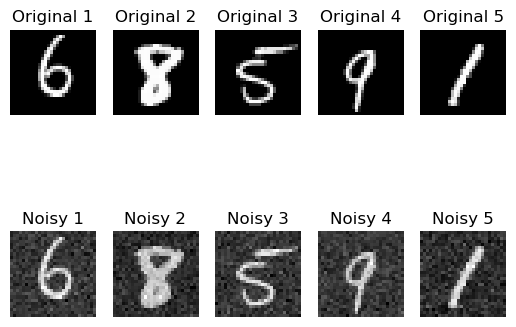

In [9]:
noisy_examples(train_loader, num_examples=5)

In [10]:
from torch.optim.optimizer import Optimizer

class EKFACDistilled(Optimizer):
    def __init__(self, net, eps):
        self.eps = eps
        self.params = []
        self._fwd_handles = []
        self._bwd_handles = []
        self.net = net
        for mod in net.modules():
            mod_class = mod.__class__.__name__
            if mod_class in ['Linear']:
                handle = mod.register_forward_pre_hook(self._save_input)
                self._fwd_handles.append(handle)
                handle = mod.register_full_backward_hook(self._save_grad_output)
                self._bwd_handles.append(handle)
                params = [mod.weight]
                if mod.bias is not None:
                    params.append(mod.bias)
                d = {'params': params, 'mod': mod, 'layer_type': mod_class, 'A': [], 'S': []}
                self.params.append(d)
        super(EKFACDistilled, self).__init__(self.params, {})

    def step(self):
        for group in self.param_groups:
            if len(group['params']) == 2:
                weight, bias = group['params']
            else:
                weight = group['params'][0]
                bias = None
            state = self.state[weight]

            self._compute_kfe(group, state)

            self._precond(weight, bias, group, state)

    def calc_cov(self, calc_act: bool = True):
        for group in self.param_groups:
            if len(group['params']) == 2:
                weight, bias = group['params']
            else:
                weight = group['params'][0]
                bias = None

            state = self.state[weight]

            mod = group['mod']
            x = self.state[group['mod']]['x']
            gy = self.state[group['mod']]['gy']

            # Computation of activation cov matrix for batch
            x = x.data.t()

            # Append column of ones to x if bias is not None
            if mod.bias is not None:
                ones = torch.ones_like(x[:1])
                x = torch.cat([x, ones], dim=0)
            
            if calc_act:
                # Calculate covariance matrix for activations (A_{l-1})
                A = torch.mm(x, x.t()) / float(x.shape[1])
                group['A'].append(A)

            # Computation of psuedograd of layer output cov matrix for batch
            gy = gy.data.t()

            # Calculate covariance matrix for layer outputs (S_{l})
            S = torch.mm(gy, gy.t()) / float(gy.shape[1])

            group['S'].append(S)

    def _compute_kfe(self, group, state):
        mod = group['mod']
        x = self.state[group['mod']]['x']
        gy = self.state[group['mod']]['gy']
        
        # Computation of xxt
        x = x.data.t() # transpose of activations

        # Append column of ones to x if bias is not None
        if mod.bias is not None:
            ones = torch.ones_like(x[:1])
            x = torch.cat([x, ones], dim=0)

        # Calculate covariance matrix for activations (A_{l-1})
        xxt = torch.mm(x, x.t()) / float(x.shape[1])

        # Calculate eigenvalues and eigenvectors of covariance matrix (lambdaA, QA)
        la, state['Qa'] = torch.linalg.eigh(xxt, UPLO='U')

        # Computation of ggt
        gy = gy.data.t()

        # Calculate covariance matrix for layer outputs (S_{l})
        ggt = torch.mm(gy, gy.t()) / float(gy.shape[1])

        # Calculate eigenvalues and eigenvectors of covariance matrix (lambdaS, QS)
        ls, state['Qs'] = torch.linalg.eigh(ggt, UPLO='U')

        # Outer product of the eigenvalue vectors. Of shape (len(s) x len(a))
        state['m2'] = ls.unsqueeze(1) * la.unsqueeze(0)

    def _precond(self, weight, bias, group, state):
        """Applies preconditioning."""
        Qa = state['Qa']
        Qs = state['Qs']
        m2 = state['m2']
        x = self.state[group['mod']]['x']
        gy = self.state[group['mod']]['gy']
        g = weight.grad.data
        s = g.shape
        s_x = x.size()
        s_gy = gy.size()
        bs = x.size(0)

        # Append column of ones to x if bias is not None
        if bias is not None:
            ones = torch.ones_like(x[:,:1])
            x = torch.cat([x, ones], dim=1)
        
        # KFE of activations ??
        x_kfe = torch.mm(x, Qa)

        # KFE of layer outputs ??
        gy_kfe = torch.mm(gy, Qs)

        m2 = torch.mm(gy_kfe.t()**2, x_kfe**2) / bs

        g_kfe = torch.mm(gy_kfe.t(), x_kfe) / bs

        g_nat_kfe = g_kfe / (m2 + self.eps)

        g_nat = torch.mm(g_nat_kfe, Qs.t())

        if bias is not None:
            gb = g_nat[:, -1].contiguous().view(*bias.shape)
            bias.grad.data = gb
            g_nat = g_nat[:, :-1]
        
        g_nat = g_nat.contiguous().view(*s)
        weight.grad.data = g_nat

    def _save_input(self, mod, i):
        """Saves input of layer to compute covariance."""
        self.state[mod]['x'] = i[0]

    def _save_grad_output(self, mod, grad_input, grad_output):
        """Saves grad on output of layer to compute covariance."""
        self.state[mod]['gy'] = grad_output[0] * grad_output[0].size(0)

In [11]:
import captum._utils.common as common
from captum.influence._core.influence import DataInfluence
from torch.nn import Module
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from torch import Tensor
import torch.distributions as dist
from torch.utils.data import DataLoader, Dataset
import tqdm


class EKFACInfluence(DataInfluence):
    def __init__(
        self,
        module: Module,
        layers: Union[str, List[str]],
        influence_src_dataset: Dataset,
        activation_dir: str,
        model_id: str = "",
        batch_size: int = 1,
        query_batch_size: int = 1,
        cov_batch_size: int = 1,
        **kwargs: Any,
    ) -> None:
        r"""
        Args:
            module (Module): An instance of pytorch model. This model should define all of its
                layers as attributes of the model. The output of the model must be logits for the
                classification task.
            layers (Union[str, List[str]]): A list of layer names for which the influence will
                be computed.
            influence_src_dataset (torch.utils.data.Dataset): Pytorch dataset that is used to create
                a pytorch dataloader to iterate over the dataset. This is the dataset for which we will
                be seeking for influential instances. In most cases this is the training dataset.
            activation_dir (str): Path to the directory where the activation computations will be stored.
            model_id (str): The name/version of the model for which layer activations are being computed.
                Activations will be stored and loaded under the subdirectory with this name if provided.
            batch_size (int): Batch size for the dataloader used to iterate over the influence_src_dataset.
            **kwargs: Any additional arguments that are necessary for specific implementations of the
                'DataInfluence' abstract class.
        """
        self.module = module
        self.layers = [layers] if isinstance(layers, str) else layers
        self.influence_src_dataset = influence_src_dataset
        self.activation_dir = activation_dir
        self.model_id = model_id
        self.batch_size = batch_size
        self.query_batch_size = query_batch_size

        self.influence_src_dataloader = DataLoader(
            self.influence_src_dataset, batch_size=batch_size, shuffle=False
        )
        self.cov_src_dataloader = DataLoader(
            self.influence_src_dataset, batch_size=cov_batch_size, shuffle=False
        )
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def influence(
            self,
            query_dataset: Dataset,
            topk: int = 1,
            additional_forward_args: Optional[Any] = None,
            load_src_from_disk: bool = True,
            eps: float = 1e-5,
            **kwargs: Any,
        ) -> Dict:

        influences: Dict[str, Any] = {}
        query_grads: Dict[str, List[Tensor]] = {}
        influence_src_grads: Dict[str, List[Tensor]] = {}

        query_dataloader = DataLoader(
            query_dataset, batch_size=self.query_batch_size, shuffle=False
        )

        layer_modules = [
            common._get_module_from_name(self.module, layer) for layer in self.layers
        ]

        G_list = self._compute_EKFAC_params()

        criterion = torch.nn.NLLLoss(reduction='sum')
        print(f'Cacultating query gradients on trained model')
        for layer in layer_modules:
            query_grads[layer] = []
            influence_src_grads[layer] = []

        for i, (inputs, targets) in tqdm.tqdm(enumerate(query_dataloader), total=len(query_dataloader)):
            self.module.zero_grad()
            outputs = self.module(inputs)

            loss = criterion(outputs, targets.view(-1))
            loss.backward()

            for layer in layer_modules:
                Qa = G_list[layer]['Qa']
                Qs = G_list[layer]['Qs']
                eigenval_diag = G_list[layer]['lambda']
                if layer.bias is not None:
                    grad_bias = layer.bias.grad
                    grad_weights = layer.weight.grad
                    grad_bias = grad_bias.reshape(-1, 1)
                    grads = torch.cat((grad_weights, grad_bias), dim=1)
                else:
                    grads = layer.weight.grad

                p1 = torch.matmul(Qs, torch.matmul(grads, torch.t(Qa)))
                p2 = torch.reciprocal(eigenval_diag+eps).reshape(p1.shape[0], -1)
                ihvp = torch.flatten(torch.matmul(torch.t(Qs), torch.matmul((p1/p2), Qa)))
                query_grads[layer].append(ihvp)

        criterion = torch.nn.CrossEntropyLoss()
        print(f'Cacultating training src gradients on trained model')
        for i, (inputs, targets) in tqdm.tqdm(enumerate(self.influence_src_dataloader), total=len(self.influence_src_dataloader)):
            self.module.zero_grad()
            outputs = self.module(inputs)
            loss = criterion(outputs, targets.view(-1))
            loss.backward()

            for layer in layer_modules:
                if layer.bias is not None:
                    grad_bias = layer.bias.grad
                    grad_weights = layer.weight.grad
                    grad_bias = grad_bias.reshape(-1, 1)
                    grads = torch.cat([grad_weights, grad_bias], dim=1)
                else:
                    grads = layer.weight.grad
                influence_src_grads[layer].append(torch.flatten(grads))
        
        for layer in layer_modules:
            query_grad_matrix = torch.stack(query_grads[layer], dim=0)
            influence_src_grad_matrix = torch.stack(influence_src_grads[layer], dim=0)
            influences[layer] = torch.matmul(query_grad_matrix, torch.t(influence_src_grad_matrix))

        return influences
            

    def _compute_EKFAC_params(self, n_samples: int = 2):
        ekfac = EKFACDistilled(self.module, 1e-5)
        loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
        for i, (input, _) in tqdm.tqdm(enumerate(self.cov_src_dataloader), total=len(self.cov_src_dataloader)):
            outputs = self.module(input)
            output_probs = torch.softmax(outputs, dim=-1)
            distribution = dist.Categorical(output_probs)
            for j in range(n_samples):
                samples = distribution.sample()
                loss = loss_fn(outputs, samples)
                loss.backward(retain_graph=True)
                ekfac.calc_cov()
                self.module.zero_grad()
        
        G_list = {}
        # Compute average A and S
        for group in ekfac.param_groups:
            G_list[group['mod']] = {}
            with autocast():
                A = torch.stack(group['A']).mean(dim=0)
                S = torch.stack(group['S']).mean(dim=0)

                print(f'Activation cov matrix shape {A.shape}')
                print(f'Layer output cov matrix shape {S.shape}')
            
                # Compute eigenvalues and eigenvectors of A and S
                la, Qa = torch.linalg.eigh(A)
                ls, Qs = torch.linalg.eigh(S)

                eigenval_diags = torch.outer(la, ls).flatten(start_dim=0)

            G_list[group['mod']]['Qa'] = Qa
            G_list[group['mod']]['Qs'] = Qs
            G_list[group['mod']]['lambda'] = eigenval_diags
            
        return G_list

In [12]:
precond = EKFACDistilled(net, eps=0.001)
influence = EKFACInfluence(net, layers=['fc1', 'fc2'], influence_src_dataset=train_dataset, activation_dir='activations', model_id='test', cov_batch_size=32)
criterion = torch.nn.CrossEntropyLoss()

for mod in net.modules():
  mod_class = mod.__class__.__name__
  print(mod_class)
  print("**********************")

SimpleNN
**********************
Linear
**********************
Linear
**********************


In [13]:
# G_list = influence._compute_EKFAC_params(n_samples=3)
# print(G_list)

In [14]:
_, test_dataset = torch.utils.data.random_split(train_dataset, [0.99, 0.01])
influences = influence.influence(test_dataset)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:15<00:00, 93.84it/s] 


Activation cov matrix shape torch.Size([785, 785])
Layer output cov matrix shape torch.Size([82, 82])
Activation cov matrix shape torch.Size([83, 83])
Layer output cov matrix shape torch.Size([10, 10])
Cacultating query gradients on trained model


100%|██████████| 480/480 [00:01<00:00, 336.25it/s]


Cacultating training src gradients on trained model


100%|██████████| 48000/48000 [01:16<00:00, 627.65it/s]


In [22]:
for layer in influences:
    print(layer)
    print(influences[layer].shape)
    print(influences[layer][0].shape)
    print(torch.argmax(influences[layer][0]))
    print(torch.argmax(influences[layer][1]))


Linear(in_features=784, out_features=82, bias=True)
torch.Size([480, 48000])
torch.Size([48000])
tensor(7944)
tensor(35158)
Linear(in_features=82, out_features=10, bias=True)
torch.Size([480, 48000])
torch.Size([48000])
tensor(17196)
tensor(13275)
